# Dask Array scales NumPy

In this notebook we demonstrate how Numpy arrays are scaled up by Dask Array:

* Blocked algorithm
* Dask.array chunks
* Parallelism
* Performance comparison
* Real example
-----

- Authors: NCI Virtual Research Environment Team
- Keywords: ND array, Dask, Numpy, Scale 
- Creation Date: 2020-May
- Lineage/Reference: This tutorial is derived from [dask tutorial](https://github.com/dask/dask-tutorial).
---

### Basics

Dask arrays coordinate many Numpy arrays, arranged into chunks within a grid. They support a large subset of the Numpy API.

<img src="https://docs.dask.org/en/stable/_images/dask-array.svg" width="80%">

Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many smaller pieces, operating on those pieces in an order that minimises the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

In this notebook, we'll build up your understanding by implementing some blocked algorithms from scratch.
We'll then use Dask Array to analyze large datasets, in parallel, using a familiar NumPy-like API.

## Set up

Choose from the following two options to create a client:

In [ ]:
# If you run this notebook on your local computer or NCI's VDI instance, you can create cluster
from dask.distributed import Client
client = Client()
print(client)

In [1]:
# If you run this notebook on Gadi under pangeo environment, you can create cluster using scheduler.json file
from dask.distributed import Client, LocalCluster
client = Client(scheduler_file='scheduler.json')
print(client)

<Client: 'tcp://10.6.61.52:8714' processes=16 threads=48, memory=202.48 GB>


<div class="alert alert-info">
<b>Warning: Please make sure you specify the correct path to the scheduler.json file within your environment.</b>  
</div>

Starting the Dask Client will provide a dashboard which is useful to gain insight into the computation. The link to the dashboard will become visible when you create the Client. We recommend having the Client open on one side of your screen and your notebook open on the other side, which will be useful for learning purposes.

## Blocked Algorithms

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

For example, consider taking the sum of a billion numbers.  We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums.

We achieve the intended result (one sum on one billion numbers) by performing many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers).

We demonstrate this concept with Python and NumPy in the following example:

In [2]:
# Load data with h5py
# this creates a pointer to the data, but does not actually load
import h5py
import os
# Provide path to data
f = h5py.File(os.path.join('/g/data/dk92/notebooks/demo_data/', 'random.hdf5'), mode='r')
dset = f['/x']

**Compute sum using blocked algorithm**

Before using dask, let's consider the concept of blocked algorithms. We can compute the sum of a large number of elements by loading them chunk-by-chunk, and keeping a running total.

Here we compute the sum of this large array on disk by 

1.  Computing the sum of each 1,000,000 sized chunk of the array
2.  Computing the sum of the 1,000 intermediate sums
3.  Computing the mean by dividing the length of the array

Note that this is a sequential process in the notebook kernel, both the loading and summing.

In [3]:
# Compute mean of large array, one million numbers at a time
sums = []
lengths = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # pull out numpy array
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
print(total / length)

0.9999990765625


`dask.array` contains these algorithms
--------------------------------------------

Dask.array is a NumPy-like library that does these kinds of tricks to operate on large datasets that don't fit into memory.  It extends beyond the linear problems discussed above to full N-Dimensional algorithms and a decent subset of the NumPy interface.

**Create `dask.array` object**

You can create a `dask.array` `Array` object using the `da.from_array` function.  This function accepts

1.  `data`: Any object that supports NumPy slicing, like `dset`
2.  `chunks`: A chunk size to tell us how to block up our array, like `(1000000,)`

In [4]:
import dask.array as da
x = da.from_array(dset, chunks=(1000000,))
x

dask.array<array, shape=(1000000000,), dtype=float32, chunksize=(1000000,), chunktype=numpy.ndarray>

#### Manipulate `dask.array` object as you would a numpy array

Now that we have an `Array`, we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. `dask_array.sum()` does not do the same thing as `numpy_array.sum()`.

**What's the difference?**

`dask_array.sum()` builds an expression of the computation but does not perform the computation. `numpy_array.sum()` computes the sum immediately.

*Why the difference?*

Dask arrays are split into chunks where each chunk must have computations run on that chunk explicitly. If the desired answer comes from a small slice of the entire dataset, running the computation over all data would be wasteful of both CPU and memory.

In [5]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

**Compute result**

Dask.array objects are lazily evaluated.  Operations like `.sum` build up a graph of blocked tasks to execute.  

We ask for the final result with a call to `.compute()`.  This triggers the actual computation.

In [6]:
result.compute()

999999100.0

Performance and Parallelism
-------------------------------

In our first example we used `for` loops to walk through the array one block at a time.  For simple operations like `sum` this is optimal. However, for complex operations we may want to traverse through the array differently.  In particular we may want the following:

1.  Use multiple cores in parallel
2.  Chain operations on a single blocks before moving on to the next one

Dask.array translates your array operations into a graph of inter-related tasks with data dependencies between them.  Dask then executes this graph in parallel with multiple threads.  We'll discuss more about this in the next section.

### Example

1.  Construct a 20,000 x 20,000 array of normally distributed random values broken up into 1000 x 1000 sized chunks
2.  Take the mean along one axis
3.  Take every 100th element

In [7]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [8]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [9]:
%%time
y.compute()     # Time to compute the result

CPU times: user 74.4 ms, sys: 6.46 ms, total: 80.9 ms
Wall time: 557 ms


array([10.00062735, 10.00120674, 10.00067785, 10.00185798,  9.99912698,
        9.99941771,  9.99986533, 10.00052396,  9.9993273 ,  9.99939046,
       10.00014753,  9.99980339, 10.00088741, 10.0002021 , 10.00116339,
       10.0005566 ,  9.99933811,  9.99932906,  9.99948317, 10.00008737,
       10.00073836, 10.00050672,  9.99908139, 10.00072962, 10.00020608,
        9.99892414, 10.0004247 ,  9.9999363 ,  9.99922363,  9.99897639,
        9.99999102, 10.00070059, 10.00013113, 10.00031286, 10.00052896,
        9.99965474,  9.99969562,  9.99963775, 10.00020166, 10.00082463,
       10.00051759,  9.99999729,  9.99982517,  9.99923643, 10.00035854,
       10.00015443, 10.00027364, 10.00099802,  9.99926859, 10.00082025,
        9.99952574,  9.99999391,  9.99980559, 10.00005534, 10.00096091,
       10.00015146, 10.00000983, 10.00102569, 10.00121878, 10.00062227,
       10.00015678,  9.99949383,  9.999794  ,  9.9997401 , 10.00009043,
        9.99984863, 10.00098944, 10.0011286 , 10.00103518,  9.99

Performance comparision
---------------------------

The following experiment was performed on Gadi using 96 cores.  Your performance may vary.  If you attempt the NumPy version then please ensure that you have more than 4GB of main memory available.

In [10]:
%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 

CPU times: user 11.9 s, sys: 504 ms, total: 12.4 s
Wall time: 12.3 s


In [11]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 71.8 ms, sys: 3.12 ms, total: 75 ms
Wall time: 558 ms


array([10.0002575 ,  9.99974537, 10.00020637, 10.00018729,  9.99936033,
        9.99891381,  9.99982933,  9.99982123,  9.9992622 , 10.00043883,
       10.00077132,  9.99979419, 10.00072896, 10.00012028, 10.00010504,
       10.00004247,  9.99927885, 10.00046337, 10.00007374, 10.00103557,
       10.00021359,  9.99893176,  9.99858209, 10.00054812, 10.0004823 ,
        9.99951197,  9.99912831, 10.00111229,  9.9990126 ,  9.99944835,
        9.99850474,  9.99954931, 10.00035794,  9.99898012,  9.99980652,
       10.00052164, 10.00054379,  9.99971416, 10.00047407, 10.00115972,
        9.99971528, 10.00130312, 10.00003221, 10.00018102, 10.00093989,
        9.99962497,  9.99962766,  9.99911803,  9.99949154,  9.9991382 ,
       10.00018357, 10.00039614, 10.00184169,  9.99981091,  9.99946998,
        9.99930913,  9.99849036, 10.00032584, 10.00042521, 10.00097547,
        9.99976028, 10.00145655, 10.00064577, 10.00010674,  9.99822944,
        9.99941051, 10.00009484,  9.99939295, 10.00134599,  9.99

**NumPy: 12s, Needs gigabytes of memory**

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 11.9 s, sys: 538 ms, total: 12.5 s
Wall time: 12.4 s
```

**Dask Array: 1s, Needs megabytes of memory**

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 126 ms, sys: 8.41 ms, total: 135 ms
Wall time: 549 ms
```

**Discussion**

Notice that the Dask array computation ran in less than 1 second, but used 126 ms of user CPU time. The numpy computation ran in 12.5 seconds and used 11.9 seconds of user CPU time.

*Questions*

*  What happens if the dask chunks=(20000,20000)?
    * Will the computation run in 4 seconds?
    * How much memory will be used?
* What happens if the dask chunks=(25,25)?
    * What happens to CPU and memory?

## Real example

### Meteorological data

There is 5GB of Australian temperature data over the past twenty years kindly provided by Morwenna Griffiths (<morwenna.griffiths@bom.gov.au>) from the Bureau of Meterology. This demo data only serves to demonstrate the dask array performance. Please refer to a proper Australian temperature data collection at [NCI's data catlogue](https://geonetwork.nci.org.au/). **Note:** the Australian Gridded Climate Data (AGCD) collection is not yet publicly available at NCI. 

The data is available in `/g/data/dk92/notebooks/demo_data/temp_data`. 

We'll use `dask.array` to compute on this dataset. Our goal is to visualize the average surface temperature in January across Australia over the last ten years. This will require a mean over all of this data.  We'll achieve this goal by running the following steps:

1.  Create `xarray.Dataset` objects for each of the days of data on disk (`dsets`)
2.  Wrap these with `da.from_array` calls 
3.  Concatenate these datasets along time with a call to `da.concatenate`
4.  Compute the mean along the newly concatenated time axis with the `.mean()` method
5.  Visualize the result with `matplotlib.pyplot.imshow`

In [12]:
from glob import glob
import os
import xarray as xr
import netCDF4  

filenames = sorted(glob(os.path.join('/g/data/dk92/notebooks/demo_data/temp_data', 'tmax*201?.nc')))
filenames

['/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2010.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2011.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2012.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2013.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2014.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2015.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2016.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2017.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2018.nc',
 '/g/data/dk92/notebooks/demo_data/temp_data/tmax_mean_0.05_2019.nc']

Let's create a list of these files and check the structure of the first one.

In [13]:
dsets = [xr.open_dataset(filename) for filename in filenames]
dsets[0]

<xarray.Dataset>
Dimensions:    (lat: 691, lon: 886, nv: 2, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01T09:00:00 ... 2010-12-31T09:00:00
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Dimensions without coordinates: nv
Data variables:
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    time_bnds  (time, nv) datetime64[ns] ...
    tmax       (time, lat, lon) float32 ...
    crs        int32 ...
Attributes: (12/33)
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    geospatial_lon_min:            111.975
    geospatial_lon_max:            156.275
    time_coverage_start:           2010-01-01T09:00:00
    time_coverage_end:             2010-01-02T09:00:00
    ...                            ...
    summary:                       The daily maximum temperature station data...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    naming_authority:              au.gov.bom
    nco_openmp_thread_number:      1
    history:                       Thu Nov  7 13:00:11 2019: ncatted -a histo...
    NCO:                           netCDF Operators version 4.7.7 (Homepage =...

The files contain variable `tmax`. What does that contain?

In [14]:
xx = dsets[0].tmax
xx

<xarray.DataArray 'tmax' (time: 365, lat: 691, lon: 886)>
[223462490 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01T09:00:00 ... 2010-12-31T09:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:                  time: maximum
    units:                         degrees_Celsius
    valid_range:                   [-100.  100.]
    analysis_version_number:       3.51
    long_name:                     Daily maximum air temperature
    number_of_stations_reporting:  729
    source:                        Interpolated surface observations
    standard_name:                 air_temperature
    frequency:                     daily
    length_scale_for_analysis:     250.0
    analysis_time:                 2011-02-23 07:04:21 UTC
    grid_mapping:                  crs

**Integrate with `dask.array`**

Make a list of `dask.array` objects out of your list of `Xarray.Dataset` objects using the `da.from_array` function with a chunk size of `(1, 691, 886)`. Why would we choose this as a chunk size? Consider the dimensions of the data. Let's just extract the January data for each year, that is, the first 31 timesteps.

In [15]:
dat = [da.from_array(dset.tmax[0:31,:,:], chunks=(1,691,886)) for dset in dsets]
dat

[dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.array<array, shape=(31, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=xarray.DataArray>,
 dask.arra

**Stack this list of `dask.array` objects into a single `dask.array` object with `da.concatenate`**

Stack these along the first axis so that the shape of the resulting array is `(31, 691, 886)`.

In [16]:
x = da.concatenate(dat, axis=0)
x

dask.array<concatenate, shape=(310, 691, 886), dtype=float32, chunksize=(1, 691, 886), chunktype=numpy.ndarray>

**Plot the mean of this array along the time axis.** As python uses 0-indexing, this is the `0th` axis.

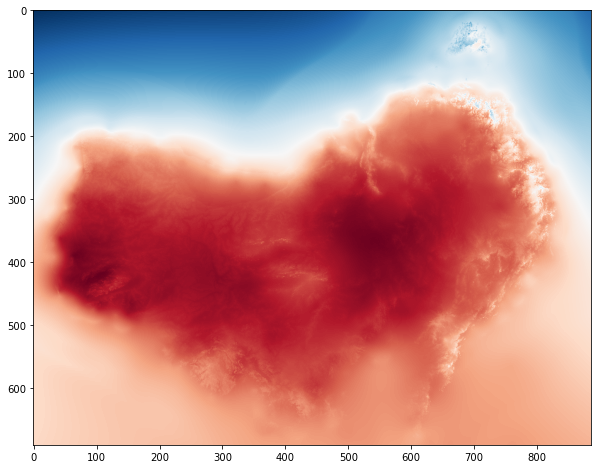

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

result = x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r');

**Plot the difference of the first day of 2009 from the mean**

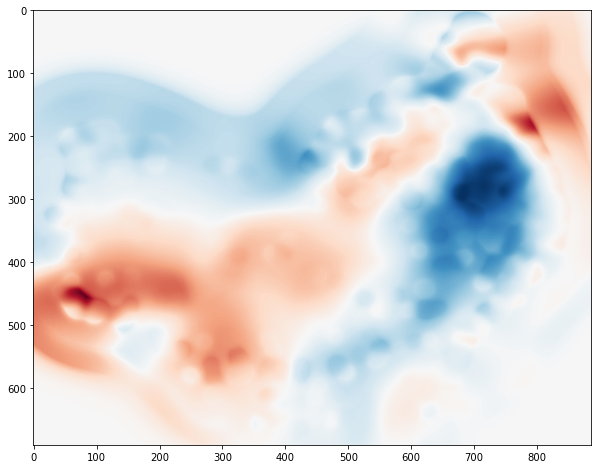

In [18]:
result = x[0] - x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r');

### Large datasets: Subsample and store

In the above exercise the result of our computation is small to handle, so we can call `compute()` safely.  Sometimes our result is still too large to fit into memory and we want to save it to disk. 

See what happens if you try to calculate the mean value over the whole 10 years of temperature data. `Hint:` You will get an error message of "worker killed".

In these cases you can use one of the following two functions

1.  `da.store`: Store dask.array into any object that supports numpy setitem syntax, e.g.

        f = h5py.File('myfile.hdf5')
        output = f.create_dataset(shape=..., dtype=...)
        
        da.store(my_dask_array, output)
        
2.  `da.to_hdf5`: A specialized function that creates and stores a `dask.array` object into an `HDF5` file.

        da.to_hdf5('data/myfile.hdf5', '/output', my_dask_array)
        
The task in this session is to **use numpy step slicing to subsample the full dataset by a factor of two in both the latitude and longitude direction and then store this result to disk** using one of the functions listed above.

As a reminder, Python slicing takes three elements

    start:stop:step

    >>> L = [1, 2, 3, 4, 5, 6, 7]
    >>> L[::3]
    [1, 4, 7]

In [19]:
import h5py
from glob import glob
import os
import dask.array as da


filenames = sorted(glob(os.path.join('/g/data/dk92/notebooks/demo_data/temp_data', 'tmax*.nc')))
dsets = [xr.open_dataset(filename) for filename in filenames]

dat = [da.from_array(dset.tmax, chunks=(1,691,886)) for dset in dsets]

x = da.concatenate(dat, axis=0)

result = x[:, ::2, ::2]

result

dask.array<getitem, shape=(7305, 346, 443), dtype=float32, chunksize=(1, 346, 443), chunktype=numpy.ndarray>

We will need to close our client in order for the `to_hdf5` operation to work.

In [20]:
client.close()

In [21]:
### Warning: this operation will create a 4.2GB file

da.to_hdf5(os.path.join('.', 'myfile.hdf5'), '/dat',result)

Limitations
-----------

Dask Array does not implement the entire numpy interface.  Users expecting this
will be disappointed.  Notably, Dask Array has the following shortcomings:

1.  Dask does not implement all of ``np.linalg``. This has been done by a
    number of excellent BLAS/LAPACK implementations and is the focus of
    numerous ongoing academic research projects.
2.  Dask Array does not support some operations where the resulting shape
    depends on the values of the array. For those that it does support
    (for example, masking one Dask Array with another boolean mask),
    the chunk sizes will be unknown, which may cause issues with other
    operations that need to know the chunk sizes.
3.  Dask Array does not attempt operations like ``sort`` which are notoriously
    difficult to do in parallel and are of somewhat diminished value on very
    large data (you rarely actually need a full sort).
    Often we include parallel-friendly alternatives like ``topk``.
4.  Dask development is driven by immediate need, and so many lesser used
    functions like ``np.sometrue`` have not been implemented purely out of
    laziness. These would make excellent community contributions.


## Reference

* [Array documentation](https://docs.dask.org/en/latest/array.html)
* [Array screencast](https://youtu.be/9h_61hXCDuI)
* [Array API](https://docs.dask.org/en/latest/array-api.html)
* [Array examples](https://examples.dask.org/array.html)